# Data Ingestion – Hierarchical Formats

> No gods, no masters.<br/>–Louis Auguste Blanqui

When we utilize machine learning models, and indeed when we perform general statistical analyses, we almost always assume our data is tabular. Observations and features; rows and columns.  And yet, there are a number of very popular ways of storing data that resemble trees rather than plowed fields.  Data objects belong to other data objects which belong to yet other data objects, with no specific limit on depth or names of branches.  Both for economy of understanding and, in the case of database systems, for efficiency of access, hierarchical data formats very often make more sense for a broad class of data.

There are many domains that simply map more naturally to hierarchies than to tables.  Yes, the relational algebra—the conceptual structure that underpins SQL and relational databases—is in some way able to represent every possible structure.  But it feels awkward for naturally hierarchical data.  For example, file systems have nested paths that eventually lead to actual files at their leaves.  Directories along the way might have indefinitely many subdirectories, with names at every level expressing something meaningful, until we get to the files which may themselves have hierarchical, tabular, or other arrangements of data.

Likewise, if we make a graph of connected web pages—or indeed of *any* kind of network, whether social, electronic communications, ecological interactions, or another—it is closer to a hierarchy than to a table.  Yes, not all, nor most, graphs are DAGs (directed acyclical graphs), but still less are they rows and colums.  Or imagine you had a "book of life" that described many biological organisms, organized by Linnaean taxonomy—domain, kingdom, phylum, class, order, family, genus, species (and perhaps sometimes subspecies, superfamily, subfamily, or tribe for example).  Not only is this hierarchial structure important data, but the leaf attributes are largely different for varying species.  Information on the dentation of prokaryotes is not going to be relevant.  Teeth are only attributes of organisms within the Chordata phylum, and mostly only within the subphylum Vertebrata. Correspondingly, attributes about hyphae are only relevant within the Fungi, Oomycota, or Actinobacteria (crossing domains, kingdoms, and phyla, but still only within a small fragment of the hierarchy). 

For better or worse, when we do data science with hierarchical data sources, that generally means that we construct a tabular abstraction of the underlying data. Depending on our purpose, either or both of the leaf attributes and branching structure might be relevant.  In either case, we want to encode those as columns of variables and rows of records.  This contrasts somewhat with many purposes outside of data science; for other purposes, it is often simply a matter of "drilling down" into the relevant leaf or distant branch, and simply presenting or modifying the small amount of information at that level.  Data science is much more often about generalizing over many different data points, concerning many different objects.

---

Before we get to the sections of this chapter, let us run our standard setup code.

In [1]:
from src.setup import *
%load_ext rpy2.ipython

In [2]:
%%capture --no-stdout err
%%R
library(tidyverse)

Now let us dive into JavaScript Object Notation as the first hierarchical format of this chapter.

## JSON

> She's a germ free adolescent<br/>
> Cleanliness is her obsession<br/>
> Cleans her teeth ten times a day<br/>
> Scrub away scrub away scrub away<br/>
> The S.R. way...<br/>–Poly Styrene

**Concepts**:

* JSON is a syntax not a semantics
* REST queries and responses
* Command-line tool `jq`
* Safe JSON readers
* NaNs, Infinities, and overflows
* Aggregating JSON records
* Working with large, deeply nested, JSON
* Extracting tabular summary of JSON data
* Validating structure with JSON Schema

JavaScript Object Notation (JSON) is a widely used data exchange format. As the name suggests, it is a format derived from JavaScript, but it is strictly language neutral. JSON is currently specified by Internet Engineering Task Force (IETF) RFC 8259.  While it can be and is used for many purposes, it is especially prevalent as a way for computer services to communicate among each other.  Hence, a large share of JSON data consists of transient messages that do not necessarily ever live on permanent storage such as as files on disk or values in a database.  Of course, sometimes those messages are logged or somehow stored, and become fruitful for data science purposes.

JSON is supported by a great many programming languages, in their standard library, as built-ins, or with widely available libraries for those languages. In syntax, JSON is very similar to, but neither exactly a superset nor subset of, native data structures in JavaScript, and to a large extent to those in Python.  An important thing to understand about JSON is that it specifies a syntax, but not a semantics.  Each language has to make decisions about how to process a text conforming with JSON grammar.

There are exactly four value types defined in JSON, and three literal values.  Whitespace is ignored throughout JSON.

* `false`, `true`, and `null` are literal values
* An *object* is a grammatical structure that is enclosed in curly braces: `{` and `}`, with strings for keys, separated by a colon from values of any syntactic type. Multiple key/value pairs are separated by commas.
* An *array* is a grammatical structure that is enclosed in square brackets: `[` and `]`, with any syntactic values separated by commas.
* A *number* optionally starts with a minus sign, followed by a sequence of digits, optionally followed by a fractional part after a decimal portion, optionally followed by an exponent.  This is mostly the same as spelling of numbers in languages like Python, R, JavaScript, Julia, C, etc., but slightly more restrictive.
* A *string* is a grammatical structure enclosed by double quotes (the code point U+0022) that may contain almost any characters.  Unicode code points may be indicated as e.g. `\u0022`, and a few special characters must be escaped with a backslash.

For example, this fragment utilizes all four value types.  The example contains an object with a string key, whose value is an array containing one each of the literal values, and two numbers.

```json
{"key": [true, false, null, 15, 55.66]}
```

### What JSON Looks Like

JSON is frequently used to interactively communicate messages among computer systems.  On my local machine I have a small demonstration web service running.   In the book repository, the directory `node-server/` contains all the code to launch it.  It happens to be written in JavaScript/Node, but it might be written in any programming language.  The key thing about it is that it provides a RESTful (representational state transfer) interface in which clients may send JSON messages and will receive other JSON messages back.  The short document shown is fairly typical of such uses.

In [3]:
# A response to an HTTP request
response = requests.get('http://localhost:3001/users') 

# Show status code, content-type, and JSON body
print(response.status_code, response.headers['Content-Type'])
response.text

200 application/json; charset=utf-8


'{"1":{"name":"Guido van Rossum","password":"unladenswallow","details":{"profession":"ex-BDFL"}},"2":{"name":"Brendan Eich","password":"nontransitiveequality","details":{"profession":"Mozillan"}},"3":{"name":"Ken Thompson","password":"p/q2-q4!","details":{"profession":"Unix Creator"}}}'

Whitespace is not significant in JSON, but it can definitely make it more readable for human examination. For example, a small function in the `setup` module for this book can do that:

In [4]:
pprint_json(response.text)

{
  "1": {
    "name": "Guido van Rossum",
    "password": "unladenswallow",
    "details": {
      "profession": "ex-BDFL"
    }
  },
  "2": {
    "name": "Brendan Eich",
    "password": "nontransitiveequality",
    "details": {
      "profession": "Mozillan"
    }
  },
  "3": {
    "name": "Ken Thompson",
    "password": "p/q2-q4!",
    "details": {
      "profession": "Unix Creator"
    }
  }
}


A command-line tool called **jq** is very useful for working with JSON data, either streamed or on disk.  A data scientist or developer who frequently works with JSON should consider learning the slightly arcane, but compact, query language `jq` provides; that is outside the scope of this book, however.  The home page for the tool, as of this writing, contains a very nice blurb for it:

> jq is like `sed` for JSON data - you can use it to slice and filter and map and transform structured data with the same ease that `sed`, `awk`, `grep` and friends let you play with text.

One very simple task `jq` can accomplish is pretty printing (indentation, line breaks, colorization, etc.).

In [5]:
with open('data/3001.json', 'w') as fh:
    fh.write(response.text)

In [6]:
%%bash
jq . data/3001.json

{
  "1": {
    "name": "Guido van Rossum",
    "password": "unladenswallow",
    "details": {
      "profession": "ex-BDFL"
    }
  },
  "2": {
    "name": "Brendan Eich",
    "password": "nontransitiveequality",
    "details": {
      "profession": "Mozillan"
    }
  },
  "3": {
    "name": "Ken Thompson",
    "password": "p/q2-q4!",
    "details": {
      "profession": "Unix Creator"
    }
  }
}


Despite its close similarity to native spelling of data structures in Python and JavaScript (and other languages), you must use a read/parse function to convert JSON to native data.  At times, a function like `eval()` in JavaScript, Python, or some other languages, will successfully convert a string to native data.  However, this is a *very bad idea*; on the one hand, it sometimes fails (even within JavaScript).  The other hand is more crucial: trying this can potentially execute malicious code contained within JSON (or pseudo-JSON).  Almost all programming languages have JSON readers/parsers as part of their standard library or widely available.  For example, in JavaScript using the Node.js runtime, we could write:

In [7]:
%%bash
js="
const fs = require('fs');
let raw = fs.readFileSync('data/3001.json');
let users = JSON.parse(raw);
console.log(users);
"
echo $js | node

{
  '1': {
    name: 'Guido van Rossum',
    password: 'unladenswallow',
    details: { profession: 'ex-BDFL' }
  },
  '2': {
    name: 'Brendan Eich',
    password: 'nontransitiveequality',
    details: { profession: 'Mozillan' }
  },
  '3': {
    name: 'Ken Thompson',
    password: 'p/q2-q4!',
    details: { profession: 'Unix Creator' }
  }
}


In Python, the equivalent is:

In [8]:
with open('data/3001.json') as fh:
    # Could also call `json.load(fh)` to read file
    raw = fh.read()
    users = json.loads(raw)
users

{'1': {'name': 'Guido van Rossum',
  'password': 'unladenswallow',
  'details': {'profession': 'ex-BDFL'}},
 '2': {'name': 'Brendan Eich',
  'password': 'nontransitiveequality',
  'details': {'profession': 'Mozillan'}},
 '3': {'name': 'Ken Thompson',
  'password': 'p/q2-q4!',
  'details': {'profession': 'Unix Creator'}}}

In R, we do not have a direct equivalent for the dictionary or hashmap structure as a standard data structure.  Hence the representation is as a *named list* (generally a nested one).  Here we only display the third element of that list for illustration.

In [9]:
%%R
library(rjson)
result <- fromJSON(file = "data/3001.json")
result[3]

$`3`
$`3`$name
[1] "Ken Thompson"

$`3`$password
[1] "p/q2-q4!"

$`3`$details
$`3`$details$profession
[1] "Unix Creator"





Other programming languages will have different spellings, but libraries or standard functions can convert between native data and JSON.

### NaN Handling and Data Types

The semi-formal description of the grammar of JSON had a covert purpose underlying its direct information.  Readers might notice things that are *missing* from it.  In particular, there is a single syntactic type named "number", but there are no distinctions among integers, floating-point, decimals, complex numbers, fractions/rationals, or the bit-length of represented numbers.  The decision of how to interpret numeric values is strictly left to libraries, or to individual users.

It may not be as obvious, but there are also some important floating-point "numbers" missing altogether.  IEEE-754 floating point numbers include the special values NaN (Not-a-Number) and Infinity/-Infinity.  To be pedantic, the binary standard represents a great many distinct bit patterns as meaning "NaN", although just one each for +Infinity and -Infinity (negative zero is another oddball number, but is less important).  JSON cannot represent those values, even though many or most programming languages have a way of spelling those value; in programming languages, typically NaN has a single spelling, such as `NaN` rather than millions of them for all the bit patterns.

In Python, the standard library and other common JSON parsers make a heuristic assumption that numbers which contain either a decimal point or an exponent are intended to represent floating-point, and numbers without them are meant to represent integers.  There are edge cases where these assumptions can fail.  Numbers like `1e309` that would fit perfectly well and exactly into Python's unlimited size integers are treated as floats, and fail as such (they *could*, however, be spelled with hundreds of trailing zeros and no decimal point to be interpreted as integers).  Probably more often relevant is that by treating JSON numbers as floats, their precision is limited to the native floating point type.  In 64-bits, this works out to 17 decimal digits; in 32-bits it is only 9 digits.  Readers normally simply loose this potential precision.

A simple example shows some of these overflow or truncation issues; here Python and R are identical, other languages may behave differently (but most are similar).

In [10]:
# An interpreted float, an overflow, and a truncation
json_str = "[1e308, 1e309, 1.2345678901234567890]"
json.loads(json_str)

[1e+308, inf, 1.2345678901234567]

In [11]:
%%R -i json_str
options(digits = 22)
fromJSON(json_str)

[1] 1.000000000000000010979e+308                          Inf
[3]  1.234567890123456690432e+00


A inclination you could easily be forgiven is to think that this issue is no more than inherent in the nature of floating point rounding.  After all, the value that is approximately $10^{308}$ is also only approximate, as we see in the long representation in the R output.  However, Python at least provides a natural alternative that more closely matches the JSON number syntax in the `decimal` module.  Unfortunately, producing values of the type `Decimal` in the standard library is cumbersome (but possible).  Fortunately, the third-party module `simplejson` makes this easy.

In [12]:
simplejson.loads(json_str, use_decimal=True)

[Decimal('1E+308'), Decimal('1E+309'), Decimal('1.2345678901234567890')]

Other languages, such as JavaScript and R lack a standard decimal or unlimited precision data type, and will simply lose precision in representing some syntactically valid JSON numbers.

A wrinkle in this story is that the default "JSON" libraries in languages like Python do not *actually* read and write JSON by default.  They read a superset of JSON, but that might includes the additional literals `NaN`, `Infinity`, and `-Infinity`.  The *JSON5* proposal includes these extensions and a few others, but is not an official standard currently. The Python standard library, for example, does not support literals of `nan`, `Nan` `inf`, `+Infinity`, or other spellings that might seem reasonable; at least not as of this writing.  Exactly what literals other languages and libraries support is up to them, and may change. Let us try some special values.

In [13]:
specials = "[NaN, Infinity, -Infinity]"
vals = json.loads(specials)
vals

[nan, inf, -inf]

Several libraries in R represent these special IEEE-754 values in a manner different than what Python libraries do. I use `rjson` in these examples, but `RJSONIO` and `jsonlite` use similar conventions.  The R solution to the underspecification is to spell its special values as strings with special values.

In [14]:
%%R -i vals
vals = c(NaN, Inf, -Inf)
print(vals)
print("R version of 'enhanced JSON':")
rjson_str = toJSON(vals)  # function from rjson library
print(rjson_str)

[1]  NaN  Inf -Inf
[1] "R version of 'enhanced JSON':"
[1] "[\"NaN\",\"Inf\",\"-Inf\"]"


This technique fails on round-tripping, even within `rjson` itself, unless you write custom code to interpret strings.  We read back the content simply as strings rather than as special numeric values.

In [15]:
%%R
print("Read back in 'enhanced JSON':")
fromJSON(rjson_str)

[1] "Read back in 'enhanced JSON':"
[1] "NaN"  "Inf"  "-Inf"


---

We can see strict JSON-compliant behavior using the JavaScript reader:

In [16]:
%%bash
js="JSON.parse('[NaN, Infinity, -Infinity]');"
echo $js | node | cat

undefined:1
[NaN, Infinity, -Infinity]
 ^

SyntaxError: Unexpected token N in JSON at position 1
    at JSON.parse (<anonymous>)
    at [stdin]:1:6
    at Script.runInThisContext (vm.js:132:18)
    at Object.runInThisContext (vm.js:309:38)
    at internal/process/execution.js:77:19
    at [stdin]-wrapper:6:22
    at evalScript (internal/process/execution.js:76:60)
    at internal/main/eval_stdin.js:29:5
    at Socket.<anonymous> (internal/process/execution.js:198:5)
    at Socket.emit (events.js:327:22)


We can also use a slightly misnamed, and cumbersome, parameter (`parse_constant`) to enforce strict mode in the Python standard library.  This catches only those specific values of special floating-point numbers spelled in the manner shown below.

In [17]:
json.loads("[NaN, Infinity, -Infinity]", parse_constant=lambda _: "INVALID")

['INVALID', 'INVALID', 'INVALID']

In other words, not just any hypothetical literal outside these particular spellings will be handed to the `parse_constant` function.

In [18]:
try:
    json.loads("[nan, +Inf, Foobar]", parse_constant=lambda _: "INVALID")
except Exception as err:
    print_err(err)

JSONDecodeError
Expecting value: line 1 column 2 (char 1)


The tool `jq` has an odd "semi-strict" behavior.  Infinity is recognized, under several spellings, but not treated as the actual IEEE-754 value "infinity."  None of these choices are per se right or wrong, but incompatibilities are dangers to stay alert for.

In [19]:
%%bash
echo "[NaN, inf, -Infinity]" | jq .

[
  null,
  1.7976931348623157e+308,
  -1.7976931348623157e+308
]


### JSON Lines

In the next subsection we look at JSON documents of substantial size and structure.  However, as we saw in the slightly fanciful example in the prior subsection, JSON is often used to encode small bundles of data.  One area where we very often encounter "small bundles of data" is in log files, such as are discussed in chapter 7 (*Feature Engineering*), chapter 3 (*Data Ingestion – Repurposing Data Sources*), and other places in this book.  The entries in log files are generally similar, and usually are arranged one per line; however, frequently different entries are required to hold different fields.  This tends to require a lot of conditional logic when parsing a log file.

*JSON streaming* is a very useful and widely used approach to reducing this burden.  Since whitespace is ignored in JSON, every document can be contained in a single line (newlines encoded as "`\n`"), and any structure and field names can be expressed with JSON syntactic structures.  This does not remove all conditional logic since the disposition of a particular entry will still often depend on the data inside it, but at least it removes the concern from the parsing step itself.

To be precise, the syntax called "ndjson" (Newline Delimited JSON) or "JSON Lines" is one of several approaches to aggregating (small) JSON documents.  Newline delimitation is the most widely used style, and is easiest to work with using command-line text processing tools which are usually line oriented.  However, you may encounter several other styles occasionally:

* Record separator-delimited: The Unicode character INFORMATION SEPARATOR TWO (U+001E) used as a delimiter (RFC 7464).  I.e. newlines may occur inside JSON document entries.
* Concatenated JSON: No delimiters used, and each JSON entry is an object or array.  This allows a streaming parser to recognize the matching `}` or `]` that will terminate the top-level structure.  Every JSON Lines stream is automatically also a Concatenated JSON stream.
* Length-prefixed JSON: Each entry consists of an integer indicating the number of bytes in the remainder of the entry, followed by a JSON object or array (in principle, a string would work too).  This has an advantage over plain concatenation in that the reader does not need to test on each character read whether a structure is completed.

Let us consider a JSON Lines example based on one in the current version of the Wikipedia article [JSON streaming](https://en.wikipedia.org/wiki/JSON_streaming).  The lines are somewhat larger than the width of these margins, so a small bash pipeline will format for a presentation length.  As shown, each line is displayed with a leading integer (which is not part of the line) and subsequent displayed lines without a leading number are part of the same line on disk (many text editors use a similar approach).

In [20]:
%%bash
cat -n data/jsonlines.log | fmt -w55 | tr -d " "

1	{"ts":"2020-06-18T10:44:13",
"logged_in":{"username":"foo"},
"connection":{"addr":"1.2.3.4","port":5678}}
2	{"ts":"2020-06-18T10:44:15",
"registered":{"username":"bar","email":"bar@example.com"},
"connection":{"addr":"2.3.4.5","port":6789}}
3	{"ts":"2020-06-18T10:44:16",
"logged_out":{"username":"foo"},
"connection":{"addr":"1.2.3.4","port":5678}}
4	{"ts":"2020-06-18T10:47:22",
"registered":{"username":"baz","email":"baz@example.net"},
"connection":{"addr":"3.4.5.6","port":7890}}


The three JSON documents, one per line, contain somewhat different fields.  All share the fields `"ts"` and `"connection"` to mark when they occurred, and from what client address.  Different kinds of events, however, require different additional fields.  This can allow command-line processing.  For example, using generic text processing tools we might list (as a JSON document) the username and email of all newly registered users. 

In [21]:
%%bash
# Extract registrations
grep "registered" data/jsonlines.log |
    sed 's/^.*registered"://' |
    sed 's/}.*/}/'

{"username":"bar","email":"bar@example.com"}
{"username":"baz","email":"baz@example.net"}


You probably notice already that the above command line could have gone wrong (because we did not choose the best tool).  If a registration object contained nested objects (that is, more closing braces `}`) we would not match the "registered" event that what we actually wanted. For that matter, if some `"username"` field were the string "registered" we would go awry as well. To do this correctly, we need actually to parse the JSON.  Here again, from the command line, `jq` is a useful tool.

In [22]:
%%bash
jq '.registered | select(.username != null)' data/jsonlines.log

{
  "username": "bar",
  "email": "bar@example.com"
}
{
  "username": "baz",
  "email": "baz@example.net"
}


Most likely, following initial exploration of a data set, for which these command-line tools are useful, we would like to perform these kinds of tasks in a general purpose programming language.  A third-party Python module `jsonlines` exists, but simply using the standard library is more than sufficient.

In [23]:
with open('data/jsonlines.log') as log:
    for line in log:
        record = json.loads(line)
        if 'registered' in record:
            user = record['registered']
            if 'username' in user:
                print(user)

{'username': 'bar', 'email': 'bar@example.com'}
{'username': 'baz', 'email': 'baz@example.net'}


In a more fleshed out version, of course, we would do something beyond just printing out the registrant information.  If one of the other variants for JSON streaming were used rather than JSON lines, the code would be somewhat more difficult, but still reasonable to program manually.

### GeoJSON

GeoJSON is a format for encoding a variety of geographic data structures which is described in IETF RFC 7946.  This book is not able to address the numerous programming and data issues that are specific to Geographic Information Systems (GIS).  A variety of specialized programming tools, books, and other learning material, is available to explore this field.  For our purposes, we merely need to understand that a GeoJSON file is a JSON file that often contains a large amount of data, and is moderately nested.  In contrast to some other formats JSON is used for, the hierarchies available in GeoJSON are not of unlimited depth, but simply consist of a variety of optional keys at several levels of nesting.

The particular data we will utilize in this subsection was generated by Eric Celeste from data published by the United States Census Bureau, describing the counties in the United States.  The public domain data was originally provided by the Census Bureau as shapefiles (`.shp`).  The GeoJSON discussed here, and the KML (Keyhole Markup Language) discussed in the next section, are mechanical transformation of the original data (the data should be equivalent).  For the example here, I use the lowest resolution shape definitions, which nonetheless amounts to fairly substantial data.

Notice that the JSON file we read, from the 2010 census, was encoded as ISO-8859-1.  In those days of yore, we were young and naïve, and the then current JSON standard had not yet mandated encoding as UTF-8.  See chapter 3 (*Data Ingestion – Repurposing Data Sources*) for a discussion of determining and working with different character encodings; I, myself, in fact, had to utilize those techniques to determine how to read this data without raising exceptions.  Let us explore the concepts slightly.

In [24]:
with open('data/gz_2010_us_050_00_20m.json', encoding='ISO-8859-1') as fh:
    counties = json.load(fh)

counties.keys()

dict_keys(['type', 'features'])

At the top level, the JSON object has a key `"type"` and one called `"features"`.  The former is simply a descriptive string, the latter where the bulk of the data lives on the 3221 counties in the United States in 2010.

In [25]:
counties['type'], type(counties['features']), len(counties['features'])

('FeatureCollection', list, 3221)

Let us look at one of those features.  We can see that it has some metadata under the key `"properties"`.  The main data is the geographic position of the boundaries of the particular county, under the key `"geometry"`.  The higher resolution data files contain the same metadata and structure of their data; the difference is that the shapes are defined by polygons with more sides, that hence more accurately describe the shape of the county in question.  What we use is more than large enough to support the examples. The actual shape, in Python terms, is a list-of-lists-of-lists.

In [26]:
counties['features'][999]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US19153',
  'STATE': '19',
  'COUNTY': '153',
  'NAME': 'Polk',
  'LSAD': 'County',
  'CENSUSAREA': 573.795},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-93.328614, 41.507824],
    [-93.328486, 41.49134],
    [-93.328407, 41.490921],
    [-93.41226, 41.505549],
    [-93.790612, 41.511916],
    [-93.814282, 41.600448],
    [-93.815527, 41.863419],
    [-93.698032, 41.86337],
    [-93.347933, 41.863104],
    [-93.348681, 41.600999],
    [-93.328614, 41.507824]]]}}

Each leaf list is simply a longitude/latitude position, a list of those is a polygon, but a county potentially has discontinguous regions that need multiple polygons to define.

As I have mentioned, there are a plethora of tools for GIS and geospatial data processing.  These include a more specialized Python module called `geojson`; within the broader Python GIS space, **Cartopy** is a well maintained package with many capabilities, and is built on top of **PROJ**, NumPy and **Shapely**.  Among other capabilities, these types of GIS tools allow visualization of longitude/latitude coordinates onto many map projections, with optional rendering of geographic and political features, and calculations based on Haversine distances rather than inaccurate Cartesian distances.  To focus just on the JSON data though, with apologies to the cartographers among my readers, let us make a flat-footed rendering to visualize USA counties.

The code below simply creates a Matplotlib figure and axis, loops through each of the features in the GeoJSON data, drills down to the coordinates, and maps the counties as patches. Visualization helps us understand the "shape" of the data we are working with. The details of the Matplotlib API are not important here.  The relevant aspect is the way that we *descend* into the nested data that was read from JSON; for example, 

```python
polk = counties['features'][999]['geometry']['coordinates'][0]
``` 

This would load the list-of-lists describing the boundaries of Polk County, Iowa.

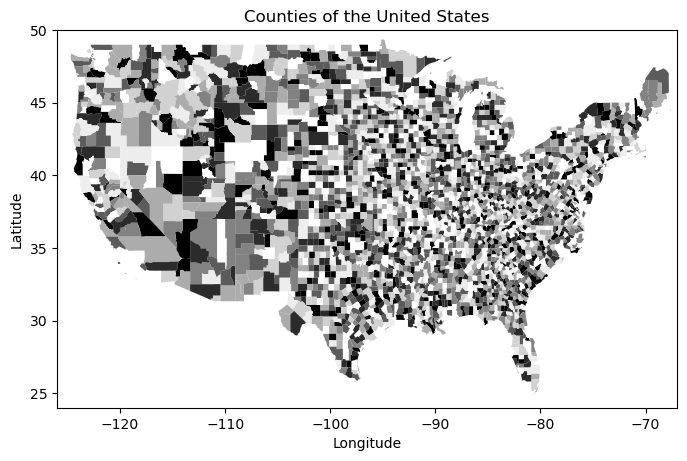

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
patches, colors, ncolor = [], [], 8

for n, county in enumerate(counties['features']):
    # Only use first polygon if multiple discontiguous regions
    poly = np.array(county['geometry']['coordinates'][0])
    poly = poly.reshape(-1, 2)
    polygon = Polygon(poly)
    patches.append(polygon)
    colors.append(n % ncolor)

p = PatchCollection(patches, cmap=cm.get_cmap('Greys', ncolor))
p.set_array(np.array(colors))
ax.add_collection(p)

ax.set_ylim(24, 50)
ax.set_ylabel("Latitude")
ax.set_xlim(-126, -67)
ax.set_xlabel("Longitude")
ax.set_title("Counties of the United States");
plt.savefig("img/(Ch02)Counties of the United States.png")

This is certainly not the best map of the United States, but the contours as a plot help us understand the data set.

### Tidy Geography

As an example of utilizing this data, apart from the visualization, we would like to create a tabular data frame that has the following columns:
    
* State Name
* County Name
* Area (square kilometers of land)
* Northernmost latitude
* Southernmost latitude
* Westernmost longitude
* Easternmost longitude

This subsection will demonstrate a bit more *code* than most do.  When dealing with hierarchical data, it is difficult to avoid some messiness.  Testing various data attributes at various levels almost always requires loops or recursion, temporary containers, lookups and memoization of data, and a number of steps that can often be handled at a much higher level with methods of a tidy data frame.

For a starting point, we can notice that the USA census provides (land) area measurement in square miles, we can use the conversion constant 2.59 for ${mi^2}/{km^2}$.  A less direct conversion is determining the state name from the FIPS (Federal Information Processing Standards) code given for the state.  Looking online at government data sources, one can locate a tab-separated description of this correspondence that we can use.

In [28]:
fips = pd.read_csv('data/FIPS.tsv', sep='\t')
fips

Name Postal Code  FIPS
0                    Alabama          AL     1
1                     Alaska          AK     2
2                    Arizona          AZ     4
3                   Arkansas          AR     5
..                       ...         ...   ...
51                      Guam          GU    66
52  Northern Mariana Islands          MP    69
53               Puerto Rico          PR    72
54            Virgin Islands          VI    78

[55 rows x 3 columns]

We would like to transform that DataFrame into a Series that takes a key of FIPS and maps to the state name.  Once we have crawled the data and levels of the JSON hierarchy we can make that mechanical transformation.

In [29]:
fips_map = fips.set_index('FIPS').Name
fips_map

FIPS
1                      Alabama
2                       Alaska
4                      Arizona
5                     Arkansas
                ...           
66                        Guam
69    Northern Mariana Islands
72                 Puerto Rico
78              Virgin Islands
Name: Name, Length: 55, dtype: object

Luckily for the task at hand, we know we need to descend at fixed depths to find the data items of interest.  In other situations, we may wish to use a recursive approach instead, with nested function calls corresponding to nested keys at indeterminate depth.  We can simply loop through counties, much as we did to create the visualization, and gather data into plain lists as a first step.

In order to factor out the processing a bit, let us first define a function that will take the collection of polygons, and return the extremes for the cardinal directions.

In [30]:
def extremes(coords):
    lat, lon = [], []
    # Expect a list of lists of lists
    for region in coords:
        for point in region:
            lat.append(point[1])
            lon.append(point[0])
    # We are assuming western hemisphere here
    north = max(lat)
    south = min(lat)
    east = max(lon)
    west = min(lon)
    return north, south, east, west

Next we would like a function to produce a DataFrame from the GeoJSON dictionary.

In [31]:
def county_summary(features):
    geo_id = []
    state, county_name, area = [], [], []
    north, south, east, west = [], [], [], []

    for county in features:
        props = county['properties']
        polys = county['geometry']['coordinates']
        geo_id.append(props['GEO_ID'])
        # District of Columbia not US state (default to None)
        state_name = fips_map.get(int(props['STATE']), None)
        state.append(state_name)
        county_name.append(props['NAME'])
        area.append(props['CENSUSAREA'] * 2.59)
        n, s, e, w = extremes(polys)
        north.append(n)
        south.append(s)
        east.append(e)
        west.append(w)

    df = pd.DataFrame({
            'geo_id': geo_id,
            'state': state,
            'county': county_name,
            'area': area,
            'northmost': north,
            'southmost': south,
            'eastmost': east,
            'westmost': west
        })
    return df.set_index('geo_id')

Although the code is fairly straightforward, it has enough in it that we would like to provide a sanity check in a unit test.

In [32]:
def test_counties(df):
    assert (df.northmost > df.southmost).all()
    assert (df.westmost < df.eastmost).all()
    assert (df.area > 0).all()

We can convert the JSON hierarchy to a tidy data frame using the `county_summary()` function we have just written, and check our boundary assumptions.

In [33]:
census_counties = county_summary(counties['features'])

# Sanity checks (if no assertion violated, we are happy)
test_counties(census_counties)
census_counties

state        county        area  northmost  southmost  \
geo_id                                                                     
0500000US01001   Alabama       Autauga  1539.58924  32.707386  32.340803   
0500000US01009   Alabama        Blount  1669.96984  34.259317  33.765316   
0500000US01017   Alabama      Chambers  1545.01529  33.108077   32.72853   
0500000US01021   Alabama       Chilton  1794.49186  33.071861  32.661732   
...                  ...           ...         ...        ...        ...   
0500000US51021  Virginia         Bland   926.50775  37.293465  36.952417   
0500000US51027  Virginia      Buchanan  1302.15617  37.537798  37.041691   
0500000US51037  Virginia     Charlotte  1230.95189  37.248759  36.697909   
0500000US51041  Virginia  Chesterfield  1096.33923  37.562631   37.22271   

                 eastmost   westmost  
geo_id                                
0500000US01001 -86.411172 -86.917595  
0500000US01009 -86.303516 -86.963358  
0500000US01017 -85.123421 -85.593177  
0500000US01021 -86.374974 -87.019157  
...                   ...        ...  
0500000US51021 -80.854627 -81.462213  
0500000US51027 -81.738378 -82.305874  
0500000US51037 -78.443319 -78.904587  
0500000US51041 -77.244167 -77.855148  

[3221 rows x 7 columns]

Exactly what analysis or modeling is relevant at this point is driven by your task.  But in general, obtaining tidy data will be a similar matter of crawling through the hierarchical structure, pulling out relevant information from varying levels.

### JSON Schema

When we tidied some GeoJSON data in the previous subsection, we made a number of assumption about exactly which keys we would encounter at which levels, nested within objects.  If these assumptions had been violated, various exceptions would be raised, or other errors would occur, in the processing functions.  It is, of course, possible to check for these situations with conditional branches, exception handling, use of methods like Python's `dict.get()`, and other similar techniques.  However, code that is cluttered with a great many such error handling constructs can have its underlying processing logic obscured.

One approach to enforcing assumptions about JSON documents is to use a JSON Schema to validate documents prior to passing them to data extraction functions. A JSON Schema is itself a JSON document following certain specifications.  At the simplest, it needs to specify a type for the JSON being validated. Within that, it can indicate what keys might occur inside objects, which are required, the cardinality of arrays, and a number of other elements, including recursive structures.  An approach of "validate, then process" is often useful; here validation merely describes the *structure* of a JSON document, it is not intended to make any claims about it containing *good data*, such as is discussed in chapter 4 (*Anomaly Detection*) and chapter 5 (*Data Quality*).

The examples below use the Python third-party module **jsonschema**, but wrap its API in a slightly different function `not_valid()`, imported from this book's `setup.py` module.  This function will return a `False` if everything is fine, but return a descriptive error message if a problem was encountered.  For example, we might validate the USA county data using the official GeoJSON schema.

In [34]:
response = requests.get('https://geojson.org/schema/GeoJSON.json')
geojson_schema = json.loads(response.text)

if msg := not_valid(counties, geojson_schema):
    print(msg)
else:
    print("Everything is Happy!")

Everything is Happy!


As hoped, the United States Census Department data is valid.  The GeoJSON schema is quite large, so I present as an example below a smaller one I developed myself.  The small "user database" web server that was queried above sends user records that are expected to follow a certain format, but the format, as development usually occurs, might only be informally specified in email threads and telephone conversations between developers.  Before running scripts to process these user records, it is useful to identify users or potential user documents that will violate the assumptions embedded in our code logic.  Let us see what information we can obtain from our example schema.

In [35]:
user_schema = json.loads("""
{
  "$schema": "http://json-schema.org/draft-07/schema#",
  "$id": "http://kdm.training/user-schema.json",
  "title": "User",
  "description": "A User of Our Computer System",
  "type" : "object",
  "required": ["name", "password"],
  "properties" : {
     "name" : {"type" : "string"},
     "password": {
         "description": "Use special characters and mixed case",
         "type": "string"},
     "lucky_numbers": {
         "description": "Up to 6 favorite numbers 1-100",
         "type": "array",
         "items": {
           "type": "number",
           "minimum": 1,
           "maximum": 100
         },
         "uniqueItems": true,
         "minItems": 0,
         "maxItems": 6
    }
  }
}
""")

This simple "User" schema does not exercise *all* the capabilities in JSON Schema, but it is a good representation.  Some metadata is contained in the keys `"$schema"`, `"$id"`, `"title"`, and `"description"`. All of these are optional in the JSON Schema specification, but their names are standard, if used.  The only key that is strictly required is `"type"` which must be one of the four JSON data types.  Within an object, keys may be required or optional; however, JSON Schema has no mechanism to *exclude* other keys that are not described.  The schema merely states that *if* a key is present, it must have values of a certain sort.

The keys `"name"` and `"password"` are required, and are both strings.  The optional description of password indicates a desire for passwords to be "good" in the sense that many computer systems enforce, but JSON Schema does not itself have a mechanism to check programmatic rules of that sort.  The key `"lucky_numbers"` describes quite a bit; not only must it have an array as a value, but that array must consist of numbers between 1 and 100, and have no more than 6 of them.  Let us look at a document that passes validation.

In [36]:
david = json.loads("""
{
  "name": "David Mertz",
  "password": "badpassword",
  "details": {
    "profession": "Data Scientist",
    "employer": "KDM"
  },
  "lucky_numbers": [12, 42, 55, 87]
}
""")

if msg := not_valid(david, user_schema):
    print(msg)

The top-level key `"details"` is not mentioned in the schema, and hence may contain anything whatsoever (anything which is valid JSON, of course).  This document validates successfully, so perhaps we would want to process it downstream.  Let us consider a few documents that fail as users.

In [37]:
barbara_feldon = json.loads("""
{
  "name": 99, 
  "password": "1ibydieZ!S@8"
}
""")

if msg := not_valid(barbara_feldon, user_schema):
    print(msg)

99 is not of type 'string'

Failed validating 'type' in schema['properties']['name']:
    {'type': 'string'}

On instance['name']:
    99


The diagnosis of the failure will hopefully provide information relevant to remediation.  This fails in a somewhat different manner, and with a more verbose description of the problem:

In [38]:
intruder = json.loads("""
{
  "password": "P4cC!^*8chWz8", 
  "profession": "Hacker"
}
""")

if msg := not_valid(intruder, user_schema):
    print(msg)

'name' is a required property

Failed validating 'required' in schema:
    {'$id': 'http://kdm.training/user-schema.json',
     '$schema': 'http://json-schema.org/draft-07/schema#',
     'description': 'A User of Our Computer System',
     'properties': {'lucky_numbers': {'description': 'Up to 6 favorite '
                                                     'numbers 1-100',
                                      'items': {'maximum': 100,
                                                'minimum': 1,
                                                'type': 'number'},
                                      'maxItems': 6,
                                      'minItems': 0,
                                      'type': 'array',
                                      'uniqueItems': True},
                    'name': {'type': 'string'},
                    'password': {'description': 'Use special characters '
                                                'and mixed case',
                    

Let us look through a few more failure messages.

In [39]:
the_count = json.loads("""
{
  "name": "Count von Count",
  "password": "fourbananas",
  "lucky_numbers": ["one", "two", "three"]
}
""")

if msg := not_valid(the_count, user_schema):
    print(msg, "\n--------------------")

'one' is not of type 'number'

Failed validating 'type' in schema['properties']['lucky_numbers']['items']:
    {'maximum': 100, 'minimum': 1, 'type': 'number'}

On instance['lucky_numbers'][0]:
    'one' 
--------------------


We failed on the data type of the nested array.  Its cardinality is checked as well.

In [40]:
george = json.loads("""
{
  "name": "Georg Cantor",
  "password": "omega_aleph",
  "lucky_numbers": [1, 2, 3, 4, 5, 6, 7, 8]
}
""")

if msg := not_valid(george, user_schema):
    print(msg)

[1, 2, 3, 4, 5, 6, 7, 8] is too long

Failed validating 'maxItems' in schema['properties']['lucky_numbers']:
    {'description': 'Up to 6 favorite numbers 1-100',
     'items': {'maximum': 100, 'minimum': 1, 'type': 'number'},
     'maxItems': 6,
     'minItems': 0,
     'type': 'array',
     'uniqueItems': True}

On instance['lucky_numbers']:
    [1, 2, 3, 4, 5, 6, 7, 8]


In one final example we see that uniqueness can be validated in an array.  This provides a way of distinguishing a set from a sequence, even though JSON itself does not distinguish those data types.

In [41]:
revolution_9 = json.loads("""
{
  "name": "Yoko Ono",
  "password": "grapefruit",
  "lucky_numbers": [9, 9, 9]
}
""")

if msg := not_valid(revolution_9, user_schema):
    print(msg)

[9, 9, 9] has non-unique elements

Failed validating 'uniqueItems' in schema['properties']['lucky_numbers']:
    {'description': 'Up to 6 favorite numbers 1-100',
     'items': {'maximum': 100, 'minimum': 1, 'type': 'number'},
     'maxItems': 6,
     'minItems': 0,
     'type': 'array',
     'uniqueItems': True}

On instance['lucky_numbers']:
    [9, 9, 9]


It is time to move on to another, much scarier, hierarchical topic.

## XML

> XML is like violence—if it doesn’t solve your problems, you are 
> not using enough of it.<br/>–Anonymous

**Concepts**:

* Defining eXtensible Markup Language
* Dialects and schemata
* Attributes and elements
* Dealing with deep and ragged nesting

The almost mandatory epigraph accompanying this section, and extending Ludwig von Rochau's notion of *Realpolitik*, is, of course, underlyingly deplorable, albeit presumably meant ironically.  I take violence always to be unacceptable, and XML only mostly so.  Both remain far too common in our world.  This corrective paraphrase only partially fixes the concern: "XML is like violence: useful only in specific situations, and totally unacceptable everywhere else."

XML (eXtensible Markup Language) is a complex format that might appear simple on its surface.  A large number of books longer than this one have been written to discuss just one or two tools or technologies associated wtih XML.  In particular, XML is not really one format so much as it is a meta-format with many dialects. Syntactically, XML is a relatively simple format that defines elements with angle bracketed tags (less-than and greater-than signs), allows attributes within tags, and has a few other syntactic forms for special entities and directives. The user records shortly below provide a minimal example. As a rough approximation, XML is a generalization of HTML; or more accurately, HTML is a dialect of XML (to be pedantic, however, recent versions of HTML are not precisely XML dialects in some technical details).

An XML dialect is usually defined by a schema which specifies exactly which tags and attributes are permitted, and the manners in which they may nest inside one another. A schema may also define the data type interpretation of particular fields. Hundreds of such dialects are widely used; for example all modern word processors and publication systems use an XML dialect to define their documents (with a compression layer wrapped around the underlying XML). Many other non-document formats use XML as well, including, for example, scientific data formats.

Several different schema languages can be used to define particular XML dialects. All of them are outside the scope of this book.  However, as a general procedure, validating an XML document prior to further processing it is almost always a good idea, if a schema is available.  This is closely analogous to the discussion in the prior section about using JSON Schema, but different tools and libraries will be used.  Probably the most commonly used means of defining an XML schema is a Document Type Definition (DTD). More modern alternatives are XML Schema and RELAX NG.  Notice that while XML Schema and RELAX NG allow declaration and validation of data types, I am not aware of any widely used tool or library that uses those type declarations when converting XML into native data structures.  Validation may assure you that a given data value, e.g., "looks like an integer," but you will still need to cast it as such within your code when you want to use it that way. 

### User Records

As a small example, I will formulate one of the user records discussed in the JSON section as an XML document.  I do not here create or specify a schema, but in principle it would be possible to have one that defined all the constraints of a valid document. As in JSON, whitespace is not (usually) significant, but can aid readability.

```xml
<?xml version="1.0" encoding="utf-8" ?>
<users>
  <user>
    <name>David Mertz</name>
    <password>badpassword</password>
    <details>
      <profession employer="KDM" duration="26" units="months">
      Data Scientist</profession>
      <telephone>+1 323 863 5571</telephone>
    </details>
    <lucky-numbers>
      <item>12</item>
      <item>42</item>
      <item>55</item>
      <item>87</item>
    </lucky-numbers>
  </user>
  <user> ... </user>
</users>
```

In XML, we have a somewhat underdetermined decision whether to put a given datum within an element body or within an attribute. The example shows both.

For this section, I will use the Python standard library XML library `ElementTree`.  Other APIs exist, even within the Python standard library, and various other programming languages have a variety of libraries and APIs available for working with XML. ElementTree makes a reasonable compromise between feeling like Python and feeling like XML.  However, if you want to work in a *more Pythonic* style with XML trees, the **lxml** library comes with an API called `lxml.objectify`.

The `lxml.objectify` API is, in turn,  based on much earlier work by my colleague Uche Ogbuji on Amara bindery, and by me even earlier on gnosis.xml.objectify.  Neither of those old projects are currently maintained, but xml.objectify is very similar and intuitive to work with.  In general lxml is a fast and well tested XML library, built on **libxml2** and **libxslt**, that provides both the objectify interface and an enhanced and faster version of ElementTree.

The two styles of data representation within an XML document is something you need to keep in mind.  There is no fundamental difference to us, as data scientists, whether data lives in an XML attribute or is the body of an element (tag).  To clarify, a *tag* is the actual word inside angle brackets (e.g. `<item>`), while an *element* is everything occuring between an opening tag and corresponding closing tag (e.g. `<item>55</item>`). Both elements and attributes can equally be useful for us.  However, in most APIs, they are accessed differently. Let us show both in a code example.

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('data/users.xml')

# Let us first find the attributes and text of a profession
prof = tree.find('user').find('details').find('profession')
print("Body (title):", prof.text.strip())
print("Attributes:  ", prof.attrib)

Within attributes we have a perfectly regular native Python dictionary that we can extract field values from.  Notice that all keys and values are simply strings.  If we wished, for example, to treat "duration" as an integer, we could cast it within our code.  As well, we often wish to loop through elements at the same level of the document hierarchy to treat them similarly.  As we saw with JSON, elements might be ragged, and contain different children, even if they share the same parent tag.

In [ ]:
items = tree.find('user').find('lucky-numbers').findall('item')
lucky_numbers = [int(item.text) for item in items]
lucky_numbers

Nested or recursive traversal, for example by calling `.findall()` at various levels of the hierarchy, is a common approach to walking an XML document. XML documents can be very large, and for those an incremental approach is available in `ElementTree` and other libraries. In the next section, a slightly more fleshed out example, we will process the same geographic data as we did in the JSON section.

### Keyhole Markup Language

KML (Keyhole Markup Language) is an XML format that is generally functionally equivalent to Shapfiles or GeoJSON.  As with those other formats, more specialized GIS (Geographic Information Systems) tools will do more than we show in this subsection.  We will need to do a little bit of magic to look for tags within the KML namespace that defines the tags within this document.  We can see that some schema and namespace information is defined at the top of the file before we get the the real "data" of the file (the "Placemark" elements).

```xml
<?xml version="1.0" encoding="utf-8" ?>
<kml xmlns="http://www.opengis.net/kml/2.2">
<Document>
  <Folder>
    <name>gz_2010_us_050_00_20m</name>
    <Schema name="gz_2010_us_050_00_20m" id="gz_2010_us_050_00_20m">
      <SimpleField name="Name" type="string"></SimpleField>
      <SimpleField name="Description" type="string"></SimpleField>
      <SimpleField name="GEO_ID" type="string"></SimpleField>
      <SimpleField name="STATE" type="string"></SimpleField>
      <SimpleField name="COUNTY" type="string"></SimpleField>
      <SimpleField name="NAME" type="string"></SimpleField>
      <SimpleField name="LSAD" type="string"></SimpleField>
      <SimpleField name="CENSUSAREA" type="float"></SimpleField>
    </Schema>
    <Placemark>
      <name>Autauga</name>
      <Style>
        <LineStyle><color>ff0000ff</color></LineStyle>  
        <PolyStyle><fill>0</fill></PolyStyle>
      </Style>
      <ExtendedData>
        <SchemaData schemaUrl="#gz_2010_us_050_00_20m">
          <SimpleData name="Name">Autauga</SimpleData>
          <SimpleData name="GEO_ID">0500000US01001</SimpleData>
          <SimpleData name="STATE">01</SimpleData>
        
... more content, eventual closing tags ...
```

An XML file can contain many namespaces that different tags live within.  So ElementTree allows us to define a dictionary mapping short names to namespace URLs to allow more convenient access.  We drill down a few levels, where just one parent node occurs, to find the "Folder" that contains the "Placemark" elements that we really care about.  These were called "features" in GeoJSON.

In [ ]:
ns = {'kml': "http://www.opengis.net/kml/2.2"}
document = ET.parse('data/gz_2010_us_050_00_20m.kml')

root = document.getroot()
kml_doc = root.find('kml:Document', ns)
folder = kml_doc.find('kml:Folder', ns)

# Make sure we have the same number of counties as with GeoJSON
placemarks = folder.findall('kml:Placemark', ns)
print("Count of placemarks:", len(placemarks))
# Show one Placemark element object
placemarks[0]

Pulling out the somewhat obscurely nested data is a bit more work than is ideal.  Let us look at what we want from the first county child node.

In [ ]:
# The name of the county is comparatively straightforward
print("County name:", placemarks[0].find('kml:name', ns).text)

# Other county info is only distinguished by attribute
sdata = (placemarks[0].find('kml:ExtendedData', ns)
                      .find('kml:SchemaData', ns)
                      .findall('kml:SimpleData', ns))

# We are going to want GEO_ID, STATE and CENSUSAREA
for record in sdata:
    print(record.attrib, record.text)

The actual name of the county is redundantly encoded in two places. Our below function, `kml_county_summary()`, should check for data integrity (i.e. consistent values). Now we need to drill into a slightly different part of the hierarchy to locate the polygon.

In [ ]:
coords = (placemarks[0].find('kml:Polygon', ns)
                       .find('kml:outerBoundaryIs', ns)
                       .find('kml:LinearRing', ns)
                       .find('kml:coordinates', ns))
pprint(coords.text)

If we consult the KML documentation, we can determine that within KML, within a "LinearRing" elements, the coordinates (polygon) take the form of `lon,lat[,alt]` structures separated by spaces.  For our task of finding the northernmost, southernmost, easternmost, and westernmost points—as we did in the GeoJSON case, the altitude will not interest us.  However, we *do* need to parse the structured raw text to get the actual boundary.  We will do that with the function `kml_extremes()`.  Since most of the actual logic is the same as in the GeoJSON version in the prior section, `kml_extremes()` can merely massage the data format slightly before calling the earlier function.

In [ ]:
def kml_extremes(coordinates):
    "Pass in a KML coordinates ElementTree object"
    text_points = coordinates.text.split()
    points = [p.split(',') for p in text_points]
    points = [[float(p[0]), float(p[1])] for p in points]
    # We pass a list-of-list-of-lists here
    return extremes([points])

kml_extremes(coords)

Next we would like a function to produce a DataFrame from the KML data.  It will be similar to that for the GeoJSON, but digging out the data is moderately different (and generally more cumbersome).

In [ ]:
def kml_county_summary(placemarks, ns=ns):
    geo_id = []
    state, county_name, area = [], [], []
    north, south, east, west = [], [], [], []

    for placemark in placemarks:
        # Get county name here and below to assure consistency
        name = placemark.find('kml:name', ns).text
        
        # Other county info is distinguished by XML attribute
        sdata = (placemark.find('kml:ExtendedData', ns)
                          .find('kml:SchemaData', ns)
                          .findall('kml:SimpleData', ns))
        # We want Name, GEO_ID, STATE and CENSUSAREA
        for record in sdata:
            rectype = record.attrib['name']  # XML attrib
            if rectype == 'Name':  # String 'Name' (county)
                # If name is recorded differently, problem!
                assert record.text == name
                county_name.append(name)
            elif rectype == 'GEO_ID':
                geo_id.append(record.text)
            elif rectype == 'CENSUSAREA':
                # Convert to km^2 from mi^2
                area.append(float(record.text) * 2.59)
            elif rectype == 'STATE':
                # District of Columbia is not a US state
                state_name = fips_map.get(int(record.text), None)
                state.append(state_name)

        # We are going to "cheat" here a little bit.  
        # Sometimes a placemark has a top level <MultiGeometry>
        # with several Polygons; we will skip that calculation 
        try:
            coordinates = (placemark
                    .find('kml:Polygon', ns)
                    .find('kml:outerBoundaryIs', ns)
                    .find('kml:LinearRing', ns)
                    .find('kml:coordinates', ns))                
            n, s, e, w = kml_extremes(coordinates)
        except AttributeError:
            n, s, e, w = None, None, None, None
            
        north.append(n); south.append(s); 
        east.append(e); west.append(w)

    df = pd.DataFrame({
            'geo_id': geo_id, 'state': state, 
            'county': county_name, 'area': area,
            'northmost': north, 'southmost': south,
            'eastmost': east, 'westmost': west
        })
    return df.set_index('geo_id')

We can convert the KML hierarchy to a tidy data frame.  Working with XML is often persnickety; often the main cause is not the physical format per se, but a tendency among creators of XML dialects to nest elements especially deeply and utilize very complex schemata.  That is somewhat the case with this KML example.

In [ ]:
kml_counties = kml_county_summary(placemarks)
kml_counties

Let us now make a great leap forward to the hundred flowers that make up configuration formats.

## Configuration Files

> The wonderful thing about standards is that there are 
> so many of them to choose from.<br/>
> –Grace Murray Hopper<sup><i>attrib</i></sup>

<div id="attrib" 
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>attrib</i><br/>    
The provenance of this quote is uncertain, though widely attributed to Admiral Hopper.  It is sometimes also credited as Andrew Tanenbaum, Patricia Seybold, or Ken Olsen.  The first of these did, indeed, use it in his <u>Computer Networks</u> (1981), but perhaps not as an original comment.
</div>

**Concepts**:

* A surfeit of slightly different formats
* Namespaces may simulate hierarchy
* INI and TOML
* YAML

Small data often lives in configuration files.  Probably the most popular of these, at least for programming projects, is now YAML (YAML Ain't Markup Language; formerly Yet Another Markup Language).  The informal INI format is also common, especially in the Windows world (but mostly in older software).  TOML (Tom's Obvious, Minimal Language) is very similar to INI, but contains a few enhancements and a stricter definition.  Sometimes JSON or XML are also used for the same purpose, although both are distinctly less human editable.  The greatest difficulty comes with numerous software projects that have, for various reasons (few of them good), adopted their own custom configuration format.

These configuration formats typically have a certain degree of hierarchy.  Depending on the format, this hierarchy might be of fixed or unlimited depth.  However, most formats allow unlimited nesting, and hence crawling them is similar to techniques we saw with JSON and XML.  

### INI and Flat Custom Formats

The exceptions to unlimited depth seem to be either Env (`.env`) files—which are also an informal convention rather than a standard—and INI files.  Env files are (usually) not actually hierarchical at all, but are simply assignments of values to names in a flat fashion.  Sometimes this can be identical to defining environment variables in a shell configuration, but often the need for quoting a value containing whitespace is omitted and character escaping rules can vary.  An INI file is often taken to allow a single level of hierarchy between the sections marked with square brackets (`[` and `]`) and assignments marked with a name and and equal sign on a single line.  Let us look at a simple INI example given in the Wikipedia article [INI file](https://en.wikipedia.org/wiki/INI_file).

```ini
; last modified 1 April 2001 by John Doe
[owner]
name=John Doe
organization=Acme Widgets Inc.

[database]
; use IP address in case network name resolution is not working
server=192.0.2.62     
port=143
file="payroll.dat"
```

At times, INI files simulate deeper hierarchies by, in concept, namespacing their section names.  So such a file might contain sections `[owner.database.systems]` and `[owner.vcs.developers]` which could by manually decoded into a hierarch of "owners."  The Python standard libary comes with a parser for this format.  This is one of the older modules in the standard library, and its API is a bit creaky.  

In [ ]:
import configparser
cfg = configparser.ConfigParser()
cfg.read('data/example.ini')

print("Sections:   ", cfg.sections())
print("Owner keys: ", [k for k in cfg['owner']])
print("Owner/name: ", cfg['owner']['name'])
print("Port #:     ", cfg['database'].getint('port'))

Data typing is limited as well.  Special methods `.getboolean()`, `.getint()`, and `.getfloat()` simply do the equivalent of the obvious type constructors.  However, Booleans, as cast with the method, are case-insensitive and recognize `yes`/`no`, `on`/`off`, `true`/`false` and `1`/`0`.

While this API is not the most natural, at least the module exists. When tools define their own formats you may need to drop to the level of manual text processing, such as is discussed in chapter 3 (*Data Ingestion – Repurposing Data Sources*), in the section "Custom Text Formats."  For example, on my system, the archaic text-based web browser, **w3m**, has a custom configuration format in `$HOME/.w3m/config` that contains lines such as these (and about 150 others):

```
tabstop 8
display_charset UTF-8
cookie_avoid_wrong_number_of_dots
accept_encoding gzip, compress, bzip, bzip2, deflate
extbrowser7 wget -c
extbrowser8 url=%s && printf %s "$url" | xsel && printf %s "$url" | xsel -b & ssl_ca_path /etc/ssl/certs
```

In general, it *appears* that the key is some alphanumeric characters followed by a space.  But what comes next might be nothing at all, it might be a string or a number, it might be a comma-separated list with more spaces, and it might even be a shell command that involves pipes, processes, and so on.  If we wanted to analyze a million users' config file, we would need to use a number of manual heuristics, or find explicit documentation of what values each key can take (if such exists).

### TOML

Tom's Obvious, Minimal Language (TOML) formalizes a number of conventions that have been used by various tools utilizing their own INI format.  Sections are marked in the same fashion, but may be nested for indefinite hierarchy.  A reasonable range of data types are formally specified by the parser.  Not every data structure can be respresented straightforwardly in TOML, but most of the most common ones can.  A great many programming languages have libraries supporting TOML, albeit as of this writing, some were only at the v0.5.0 level of support rather than v1.0.0-rc.1 (but the differences are very small).

The following is an example given in the TOML documentation:

```
# This is a TOML document.

title = "TOML Example"

[owner]
name = "Tom Preston-Werner"
dob = 1979-05-27T07:32:00-08:00 # First class dates

[database]
server = "192.168.1.1"
ports = [ 8001, 8001, 8002 ]
connection_max = 5000
enabled = true

[servers]

  # Indentation (tabs and/or spaces) is allowed but not required
  [servers.alpha]
  ip = "10.0.0.1"
  dc = "eqdc10"

  [servers.beta]
  ip = "10.0.0.2"
  dc = "eqdc10"

[clients]
data = [ ["gamma", "delta"], [1, 2] ]

# Line breaks are OK when inside arrays
hosts = [
  "alpha",
  "omega"
]
```

Having a formal parser available avoids a great deal of the manual logic of custom formats.  Moreover, the API here is quite modern in that it simply converts a configuration file to a native data structure, with no need for unusual special methods to get at the underlying data.  Having native support for a datetime data type is a handy convenience (which JSON lacks); strings, numbers (float/int), lists, and dictionaries are supported. The top level of every TOML document is always a mapping, however that might be represented in a particular programming language.  Let us take a look at an example.

In [ ]:
import toml
toml.load(open('data/example.toml'))

One big advantage of having a parser available is that typically it will report (relatively) helpfully on what went wrong.  I created a slightly wrong version of the same TOML file, intended to resemble errors human typists might often make.  The error message itself does not, perhaps, provide complete clarity about what went wrong; at least it tells us where to look for it though.

In [ ]:
with open('data/example-bad.toml') as fh:
    try:
        cfg = toml.load(fh)
    except Exception as err:
        print_err(err)

Let us print part of the TOML file.

In [ ]:
!cat -n data/example-bad.toml | tail -8

With human eyes, we can detect the problem easily enough. Line 27 has some formatting problems, although exactly what was intended is not entirely obvious.  Generally manual remediation is required to reconstruct the original intention.

Just to demonstrate another programming language, reading TOML into R is very similar. Specifically, this also gives us a (nested) native data structure with a single call.

In [ ]:
%%R
library(RcppTOML)
parseTOML("data/example.toml")

### Yet Another Markup Language

YAML occupies a similar space as JSON and XML, but with a heavy emphasis on human readability and editability.  Both of those latter had an initial impetus, in part, to be human readable and editable formats, but neither succeeds well in such a goal; yes they are textual, but for both it is easy to make subtle syntax or grammatical mistakes.  YAML comes much closer.

In its basic form, YAML documents are quite readable and present an intuitive view of their structure.  Things can get more complicated with tags and directives, and by the time you get to language-specific schemata, much of the generic readability is diminished.  However, 99% of YAML documents utilize only the very accessible subset that remains simple, yet powerful.  Let us look at an example adapted from the YAML tutorial.

```
invoice: 34843
date   : 2001-01-23
bill-to: &id001
    given  : Chris
    family : Dumars
    address:
        lines: |
            458 Walkman Dr.
            Suite #292
        city    : Royal Oak
        state   : MI
        postal  : 48046
ship-to: *id001
product:
    - sku         : BL394D
      quantity    : 4
      description : Basketball
      price       : 450.00
    - sku         : BL4438H
      quantity    : 1
      description : Super Hoop
      price       : 2392.00
tax  : 251.42
total: 4443.52
comments:
    Late afternoon is best.
    Backup contact is Nancy
    Billsmer @ 338-4338.
```

There are a few subtleties in this simple document.  A very large variety of data types are recognized based on syntactic patterns, much as we can spell constants of many types in programming languages, which a parser distinguishes.  Quoting is rarely needed, but is permitted (for example, if a string happens to contain numeric digits only, and you do not wish it to be treated as a number).

The overall structure of this document is a mapping from several names to their values.  In some cases, those values are themselves sequences or mappings, in other cases they are scalars.  Strings may be multiline, with a pleasant subtlety that beginning with a pipe (`|`) indicates that newlines should be preserved (but other indentation is ignored).  The address lines in the above example show this. In the case of the key `comments` the string occupies multiple lines, but newlines are not preserved.

A powerful feature is the availability of anchors and references.  These are vaguely inspired by C-family languages that have references and pointers.  The idea is that a fragment of a document may be named (an anchor) and referenced elsewhere.  This avoids repetition but also, more importantly, assures consistency in the contents.  We see this where a person with address is defined in relation to the `bill-to` but referenced under the key `ship-to`.

Let us see what the data looks like when read into native Python data structures.

In [ ]:
import yaml
order = yaml.load(open('data/example.yaml'))
order

As with TOML, dates are handled natively.  The anchor and reference are expanded into references to the same nested dictionary.  Some numbers are parsed as floats, others as ints, using the same spelling rules as most programming languages.  Notice that an initial dash introduces an item of a seqence/list as opposed to a key in a mapping/dictionary. Look back at the YAML version of the invoice to see this.

We can verify that referenced objects are simply references, not full copies.

In [ ]:
# Is nested dict same object under different keys?
order['ship-to'] is order['bill-to']

Remember that several different enhancements are used to enable JSON streaming, the most common beeing JSON Lines.  YAML thought of this in its initial design, and inherently builds in specific elements for multiple documents in the same stream, while still allowing each component document to use whatever whitespace that makes it the most readable (obviously, subject to the grammar of YAML, but it is flexible).  For example, here is a single file that contains multiple documents; it could equally be any other Python file-like object with a `.read()` method though (i.e. including an infinite stream).

```
%YAML 1.1
---
# YAML can contain comments like this
name: David
age: 55
---
name: Mei
age: 50     # Including end-of-line
---
name: Juana  
age: 47
...
---
name: Adebayo
age: 58
...
```

The version directive at the start is optional, but is good practice.  Three dashes alone on a line indicate the start of a document.  Starting a new document sufficed to indicate the last one ends.  However, three dots are also available to explitly mark the end of a document.  We might loop through these multiple documents, and process each one in some manner, as in the code below.  In a data science context, we generally expect each document to contain similar structure and "fields" but that is not a constraint of the YAML format itself.

In [ ]:
with open('data/multidoc.yaml') as stream:
    docs = yaml.load_all(stream)
    print(docs, '\n')
    for doc in docs:
        print(doc)

As we discussed with TOML, one of the biggest advantages to working with a formally specified format with developed tools—even, or especially, if it is a format often manually edited by humans—is that parsers will hopefully produce meaningful messages about formatting problems without us needing to catch them manually.

In [ ]:
try:
    yaml.load(open('data/example-bad.yaml'))
except Exception as err:
    print_err(err)

With the error message in hand, we might look at the portion of the document that indicates a problem.  It is not too difficult to identify the problem on line 17.  In this case, the error is intentionally obvious.

In [ ]:
%%bash
cat -n data/example-bad.yaml | sed '15,19p;d' 

Similarly, if we try to parse a YAML stream, it will succeed up until the point that it encounters the bad document.  This has to be true, since the grammatically incorrect document in the stream is not even *read* until the iterator gets to it. We can confirm this by trying to print out each document as it is read.

In [ ]:
try:
    for doc in yaml.load_all(open('data/multidoc-bad.yaml')):
        print(doc)
except Exception as err:
    print_err(err)

We have looked at the most important configuration file formats; let us return to big data.

## NoSQL Databases

> Das ist nicht nur nicht richtig; es ist nicht einmal falsch!<br/>
> –Wolfgang Pauli<sup><i>notwrong</i></sup>

<div id="notwrong" 
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>notwrong</i><br/>
In English: "That is not only not right; it is not even wrong."  Pauli's colorful phrase is usually circulated simply as the description "not even wrong."  In general understanding, his intent is taken as meaning "unfalsifiable."
</div>

**Concepts**:

* Graph databases
* Document-oriented databases
  * Missing fields in ragged documents
  * Denormalization and data integrity
* Key/value stores
  * Informal hierarchies

A number of database systems avoid the relational model, usually with the goal of better performance within a particular domain.  As well, many RDBMs now include JSON and XML data types. In overview, these systems break down into documented-oriented databases, graph databases, and key/value stores.  Specific server software may combine elements of these—or indeed elements of relational databases—and the specific performance characteristics, design philosophy, and general limitations, vary among each project.

Most of the "NoSQL" database systems have a prominent attribute suggested by the moniker; namely, using query languages other than SQL.  However, even there, some of them nonetheless implement at least a subset of SQL as a method of accessing data.  These other query languages are sometimes unique to a particular database system, but in some cases are somewhat standardized.  For example, the graph query languages **Gremlin**, **SPARQL** (SPARQL Protocol and RDF Query Language), and **GQL** (Graph Query Language; formerly *Cypher*) are each supported by several different database systems.  Among open source graph databases, the most well known are perhaps **Neo4j** and **OrientDB**, but numerous others exist, including many proprietary ones.

Beyond mentioning here that they exist, I will not discus in this book anything specific about data cleanliness issues that are characteristic of graph databases.  The types of data analyses performed on graphs are typically somewhat specialized and outside the scope of what I can discuss here.  But you may encounter data in these formats.  I will discuss in somewhat more detail document-oriented databases and key/value stores, both of which you are more likely to find yourself working with (for most readers; individual needs and jobs vary, of course).

In broad concept, graph databases consist of nodes, and edges that connect nodes; both nodes and edges can usually hold attributes or properties, either free form per object, or defined by a schema.  For example, the node representing me might contain my name ("David"), my occupation ("Data Scientist"), and my current home state ("Maine").  In turn, I have a "social graph" that inclues my connection/edge labeled "Friend" (that perhaps contains other properties) to the node "Brad."  I also have a connection labeled "Publisher" to the node "Packt."  A complete social graph may consist of millions of nodes and edges, with various attributes attached to each.

A small illustration in the public domain was created by uer Ahzf for the Wikimedia Commons:

<img src="img/GraphDatabase_PropertyGraph.png" alt="Graph Database Illustration" width="500px"/>

### Document-Oriented Databases

Document-oriented databases typically store and communicate their data using XML, YAML, JSON, or BSON (Binary JSON).  In a sense, you can think of these databases simply as single giant files in one of these formats, which just happen to have mechanisms to index and optimize queries into them. In actual implementation, this will not be true, but as a conceptual model it does not go far astray.  The key thing to understand in document-oriented databases is that their data is hierarchically organized.  This can make some access patterns very efficient, but it comes with all the same pitfalls as other hierarchical formats.

Popular open source document-oriented databases include **MongoDB**, **CouchDB**, **CrateDB**, **Elasticsearch**, and **Solr**.  This software space is well occupied, and a large number of other tools, both open source and proprietary, are not included in my list.  In broad concept, especially in terms of data cleanliness concerns, these different projects are similar.

The main pitfall in hierarchical data is simply that it is ragged.  Particular fields at particular levels of nesting might be missing.  Let us illustrate with an example inspired by a MongoDB blog post about restaurants with reviews.  For these illustrations we use MongoDB which is based around JSON.  The same concepts would apply to any document-oriented database.  As with other examples in this book, security configuration and login credentials will be part of normal usage, but are not addressed here. 

In [ ]:
# Assume that MongoDB is running on local system
from pymongo import MongoClient
client = MongoClient('mongodb://localhost:27017')

We can check what databases exist on this server.  Other than "business", the others are administrative in nature, and simply exist by default on every MongoDB installation.

In [ ]:
# What databases exist on the local server?
client.database_names()

The "business" database has two branches at its top level.  One for reviews, another for info.  A document-oriented database is typically organized as in a hierarchy of server → database → collection → document.  For comparison, a relational database is organized as server → database → table → row. Let us look at a few documents from each.  General "info" on the first few restaurants:

In [ ]:
db_biz = client.business
print("Restaurants:", db_biz.info.count())
for biz in db_biz.info.find(limit=3):
    pprint(biz)

Similarly, here are the first few reviews.  Each review pertains to one of the listed restaurants in the "info" branch.

In [ ]:
print("Reviews:", db_biz.reviews.count())
for review in db_biz.reviews.find(limit=3):
    pprint(review)

We might make a more specific inquiry.  For example, perhaps we are interested in those reviews of "City Kitchen Inc." which consider the price "cheap".  We can see that different diners who evaluated the price the same rated the restaurant differently.  In principle, other data might be attached to each of these documents, of course. MongoDB's query language is itself expressed as JSON (or as Python dictionaries from the Python interface).

In [ ]:
query = {'price': 'cheap', 'name': 'City Kitchen Inc.'}
for review in db_biz.reviews.find(query, limit=4):
    pprint(review)

#### Missing Fields

In our general preview of the "business" database, everything was completely regular.  We might jump into writing some code that crawls through records of a certain sort, perhaps matching a certain filter, with the intention of performing aggregation or modeling on corresponding data fields.  For example, perhaps we would like to generate a histogram of the ratings given to "City Kitchen Inc."  The danger here is that some reviews might not *have* ratings, which we handle below using a try/except block.

In [ ]:
ratings = []
query = {'name': 'City Kitchen Inc.'}
for review in db_biz.reviews.find(query):
    try:
        ratings.append(review['rating'])
    except KeyError:
        pass

n = len(ratings)
pd.Series(ratings).plot(kind="hist", title=f"{n} ratings")
plt.savefig(f"img/(Ch02){n} ratings.png")

We can see what is missing if we ask MongoDB for the actual number of rows.  Our loop indeed skipped some data.

In [ ]:
db_biz.reviews.find({'name': 'City Kitchen Inc.'}).count()

MongoDB—or any other hierarchical database (with perhaps some variation in API)—will let you match documents based on missing fields.  In this small example, there is not that much other data in each document to consider, but in real world cases there might be many and diverse fields in similar documents. Let us list the reviews which do not have an associated rating.

In [ ]:
list(db_biz.reviews.find({'name': 'City Kitchen Inc.', 'rating': None}))

Whether or not you need to worry about these two reviews with missing ratings is problem and domain driven.  You might want to ignore them.  You might want to perform techniques such as those discussed in chapter 5 (*Data Quality*) and chapter 6 (*Value Imputation*).  In any event, you should be conscious of the fact that your data is incomplete.

#### Denormalization and Its Discontents

For performance reasons that are analogous to those in relational databases, sometimes data is denormalized in document-oriented databases.  Querying within one branch will be faster, and querying just one document will be much faster again.  Hence, administrators of document-oriented databases will commonly duplicate information into a location "closer" to where it is typically accessed.

In querying a document-oriented database, we might use code similar to this:

In [ ]:
def has_best_review(name, db=db_biz):
    "Return phone if restaurant has at least one 10 rating"
    query = {'name': name, 'rating': 10}
    review = None
    
    # Fast path has phone in local results
    for review in db.reviews.find(query):
        phone = review.get('phone')
        if phone:
            return f"Call {name} at {phone}! (FAST query)"

    # If there were no ratings of 10, we don't like it!
    if not review:
        return f"Do not bother with {name}!"

    # MUCH SLOWER path is second query
    info = db.info.find_one({'name': name})
    return f"Call {name} at {info['phone']}! (SLOW query)"

Perhaps when a review is consulted numerous times (for example, if it had an actual description field), the database administrator may cache the phone number that is usually wanted within the actual review document.  Let us see how several inquiries behave.

In [ ]:
has_best_review('Salty Big Take-Out')

In [ ]:
has_best_review('City Kitchen Inc.')

In [ ]:
has_best_review('Out of Business')

On its face, this all seems like reasonable performance optimization.  The problem is that *duplicated* information is information that *might be* inconsistent.  Here we will use the database itself to look for non-absent fields (the example function could be improved using this query element also).

In [ ]:
query = {'name': 'Salty Big Take-Out', 
         'rating': 10, 'phone':{"$ne":None}}

db_biz.reviews.find_one(query)

However, let us take a look at the "info" branch for this restaurant rather than the "reviews" branch we have focused on so far.

In [ ]:
db_biz.info.find_one({'name': 'Salty Big Take-Out'})

At this point we are faced with a data integrity problem.  Presumably, at *some point* the telephone number was copied into the review document.  It is *plausible* that the phone number was copied from the "info" branch to the "reviews" branch at the time the review was created (or maybe on the thousandth access to it?); that would suggest that the "info" branch is more current.  However, it is also *possible* that the phone number was entered with the review itself as an option.  Determining the cause of the data integrity problem, unfortunately, depends on understanding not only the code that might have run in the past, but also even the human or automated entry processes that might have occurred.

### Key/Value Stores

The simplest possible database system is a key/value store.  These systems do nothing more than map some key (usually a string) to a value (sometimes a string, sometimes compound types).  Often these systems are used as in-memory data stores to allow the fastest possible access, often as a form of caching.  However, most of the systems that usually operate in-memory—including among distributed servers—also have some persistence mechanism such as virtual memory or snapshotting.  Other variations of key/value stores are primarily on-disk formats, but they might in turn reside primarily in cache memory, hence achieving similar speed.

**Redis** (Remote Dictionary Server) and **Memcached** are popular in-memory systems (with persistence mechanisms on the side).  Memcached, as its name suggests, is most commonly used as a cache, and is hence much less commonly a "source of knowledge."  That is, a cache frequently sits between a client and a server and simply records the previous result from a client.  If an identical request occurs again (possibly limited to some "staleness" period) then the complex database query, or difficult computation, or access to additional resources external to the server, can be skipped and the cached result is returned instead.  Redis is sometimes used this way, but is also often used as a definitive or sole source of knowledge for some element of the data needed by a server.

To illustrate this caching in pseudo-code, a server proxy might contain code similar to this:

```python
request = get_client_request()
key = hash(request)   # Collision resistant hash

# See if FAST PATH is available
if result := check_for_cache(key):
    send_to_client(result)
    
# SLOW PATH as fallback
else:
    result = expensive_operation(request)
    send_to_client(result)
    store_to_cache(key, result, expiration=duration)
```

Other key/value stores are derived from the early Unix DBM (Database Manager) system.  These include **LDBM** (Lightning Memory-Mapped Database), **GDBM** (GNU dbm), and **Berkeley DB**.  All of these simply map byte strings to other byte strings, without addressing more complex data structures.  In contrast, for example, Redis allows for values to have a rich collection of data types, including collections allowing nesting.  In practice, however, bytes are sufficient to hold any kind of data; it is just a matter of those bytes representing some serialization format, such as JSON texts, or Python pickles (the Python `shelve` module, for example, is basically just DBM coupled with pickles).

Being primarily single files on disk that store key/value pairs, DBM-family libraries occupy a similar application space with SQLite single-file databases.  Both are a way to encapsulate related data into a format that can be read universally, and depends only on a single file to be shared.  Obviously, the manner of use is different between relational and key/value stores, but the same information can easily be represented in either, and both provide their own kind of querying and updating interfaces.

In a sense, key/value stores are simple enough that they do not lend themselves to data integrity problems.  Obviously, it is always possible to store values that are simply *wrong* no matter what format is used.  But there is nothing in the structure of a mapping itself which adds special concerns. Or so it would seem.

Problems arise in practice because users actually *want* hierarchy in their data.  Most keys are not useful as completely flat names.   Developers commonly invent ad hoc hierarchies in the keys used within key/value stores; this is not a necessarily or usually a bad habit by developers, it usually reflects a genuine requirement of the problem space.  However, these hierarchies can be especially fragile.

For example, I have created a DBM file that contains similar information to the restaurant database discussed above in its MongoDB format.  The hierarchy of branches is represented here using namespacing of the keys with delimiters.  This approach is quite commonplace among creators of key/value store systems.  Let us look at a few of the keys in this key/value store.  I have used a random seed that happens to sample some keys of interest.

In [ ]:
biz = dbm.open('data/keyval.db')
seed(6)
# Keys are bytes; could convert to strings if desired
sample(list(biz.keys()), 10)

We can query on various informally hierarchical keys.

In [ ]:
name = b"Tasty Fish Inc."
print("Overview:", biz[b"DESCRIPTION"])
print("Cuisine: ", biz[name + b"::info::cuisine"] )
print("Ratings: ", biz[name + b"::ratings"][:30], "...")

As is common, I have created an informal sequence in the "ratings" value by using delimeters.  Consumers of the data will simply have to be aware that a particular value is formatted that way.  We might even use a small amount of code to pull related keys out from the ad hoc hierarchy.

In [ ]:
for key, val in biz.items():
    if key.startswith(b'Tasty Fish Inc.::'):
        print(key.decode(), '\t', val[:30].decode())

The main problem that arises here is that over the course of using the database, an inconsistent convention for hierarchical keys was used.  This is a general concern, and occurs frequently in real data; it is probably especially prominent in multi-user, multi-consumer systems like Redis that are likely to communicate with tools written by many people, in many languages, over time.  Data integrity failures just tend to seep in.  For example:

In [ ]:
for key, val in biz.items():
    if key.startswith(b'Fish City Restaurant'):
        print(key, val[:30])

Although the intent of the differently delimited hierarchical keys is easy to discern as human readers, detecting such inconsistencies can be laborious, and you risk missing information with inadequate remediation.  For these types of key/value stores, if you need to utilize their data source, a good first examination is to analyze the structure of keys themselves.  They will not always utilize an ad hoc hierarchy, but doing so is frequent.  Even if there are millions of keys rather than the hundreds in my example, that initial approach can at least assure that consistent path components exist using consistent delimiters (or other formatting of keys).

We have covered a large number of different hierarchical formats, and even so left out much possible discussion of others.  An in-depth look at graph databases will need to live in a different book. As well, many volumes have been written on the myriad APIs and dialects of XML, that this chapter only gestures at.  However, I hope this has given you a feel for the kinds of concerns that arise with this family of data sources.

## Exercises

The two exercises here deal first with refining the processing of the geographic data that is available in several formats.  The second exercise addresses moving between a key/value and relational model for data representation.

### Exploring Filled Area

Using the United States county data we created tidy data frames that contained the extents of counties as simple cardinal direction limits; we also were provided with the "census area" of each county.  Unfortunately, the data available here does not specifically address water bodies and their sizes, which might occur within counties.

The census data can be found at:

> https://www.gnosis.cx/cleaning/gz_2010_us_050_00_20m.json

> https://www.gnosis.cx/cleaning/gz_2010_us_050_00_20m.kml

> https://www.gnosis.cx/cleaning/gz_2010_us_050_00_20m.zip


In this exercise you will create an additional column in the data frame illustrated in the text to hold the percentage of the "bounding box" of a county that is occupied by the census area.  The trick, of course, is that the surface area enclosed by latitude/longitude corners, is not a simple rectangle, nor even a trapezoid, but rather a portion of a spherical surface.  County shapes themselves are typically not rectangular, and may include discontiguous regions.

To complete this exercise, you may either reason mathematically about this area (the simplifying assumption that the Earth is a sphere is acceptable) or identify appropriate GIS software to do this calculation for you.  The result of your work will be a data frame like that presented in the chapter, but with a column called `"occupied"` that contains 3221 floating point values between 0 and 1.

For extra credit you can investigate or improve a few additional data integrity issues.  The Shapefile in the zip archive is the canonical data provided by the US Census Bureau.  The code we saw in this chapter to process GeoJSON and KML actually produce slightly different results for latitude/longitude locations, at the third decimal place.  Presumably, the independent developer whom I downloaded these conversions from allowed some data error to creep in somehow.  Diagnose which version, if either, matches the original `.shp` file, and try to characterize the reason for and degree of the discrepency.

For additional extra credit, fix the `kml_county_summary()` function presented in this chapter so that it correctly handles `<MultiGeometry>` county shapes rater than skipping over them.  How often did this problem occur among the 3221 United States counties?

### Create a Relational Model

The key/value data in the DBM restaurant data is organized in a manner that might provide very fast access in Redis or similar systems.  But there is certainly a mismatch with the implicit data model.  Keys have structure in their hierarchy, but it is a finite and shallow hierarchy.  Values may be of several different implicit data types; in particular, ratings are stored as strings, but they really represent sequences of small integer values.  Other fields are simple strings (albeit stored as bytes in the DBM).

The `dbm` module in the shown example uses Python's fallback "dumb DBM" format which does not depend on external drivers like GDBM or LDBM.  For the example with hundreds of records this is quite fast; if you wished to used millions of records, other systems would scale well and are preferred.  This "dumb" format actually consistes of three separate files, but sharing the `keyval.db` prefix; the three are provided as a zip archive.

In [ ]:
dbm.whichdb('data/keyval.db')

The "dbm.dumb" format is not necessarily portable to other programming languages.  It is, however, simple enough that you could write an adapter rather easily.  To provide the identical data in a more universal format, a CSV of the identical content is also available:

> https://www.gnosis.cx/cleaning/keyval.zip

> https://www.gnosis.cx/cleaning/keyval.csv

For this assignment you should transform the key/value data in this example into relational tables, using foreign keys where appropriate, and making good decisions about data types.  SQLite is an excellent choice for a database system to target; it is discussed in chapter 1 (*Data Ingesion – Tabular Formats*).  Any other RDBMS is also a good choice if you have administrative access (i.e. table creation rights).  Before transforming the data model, you will need to clean up the inconsistencies in the hierarchical keys that were discussed in this chapter.

The names of restaurants are promised to be distinct; however, for foreign key relationships, you may wish to normalize using a short index number standing for the restaurants uniformly.  The separate ratings should definitely be stored as distinct data items in a relevant table.  To get a feel for more fleshed out data, invent timestamps for the reviews, such that each is mostly distinct.  A real-world data set will generally contain review dates; for the example no specific dates are required, just the form of them.

Although this data is small enough that performance will not be a concern, think about what indices are likely to be useful in a hypothetical version of this data that is thousands or millions of times larger.  Imagine you are running a popular restaurant review service and you want your users to have fast access to their common queries.

Using the relational version of your data model, answer some simple queries, most likely using SQL.

* What restaurant received the most reviews?
* What restaurants received reviews of 10 during a given time period (the relevant range will depend on which dates you chose to populate)?
* What style of cuisine received the highest mean review?

For extra credit, you may go back and write code to answer the same questions using only the key/value data model.

## Denouement

> Simple is better than complex.<br/>
> Complex is better than complicated.<br/>
> Flat is better than nested.<br/>
> Sparse is better than dense.<br/>
> Readability counts.<br/>–Tim Peters (The Zen of Python)

**Topics**: JSON; JSON Lines; JSON Schema; XML; YAML and Configuration Files; Document-Oriented Databases; Key/Value Stores.

Hierarchical data often provides a much better representation of *entities* that have attributes and relationships to each other than does flat data.  In object-oriented programming, but also simply in ordinary taxonomies and ontologies, the relationships "Is-A" and "Has-A" are frequently fundamental, and neither of those is whatsoever tabular.  Or at best, even the attributes captured by *has-a* relationships are ragged and sparse, and definitely not tidy.  Moreover, *is-a* relationships are hierarchical at their core.

There is often—even usually—an impedance mismatch between hierarchical data and data science.  Much of these issues comes down to *access patterns*.  For many software applications, what interests us are particular entities that carry with them heterogeneous bundles of data, each bundle pertaining to the kind of thing the entity is an instance of.  In utilzing such applications, we only care about one *thing* (or a handful of things) at a given time.  When that is the case, hierarchical data structures can often be both more efficient and conceptually closer to the underlying ideas the data represents.

When we do data science, whether it is general statistics, data visualization, or machine learning models, we are concerned with collections of records or samples that are homogeneous in regard to our purpose or goal.  Yes, there may be missing data concerns such as those addressed in chapter 4 (*Anomaly Deterction*) and chapter 5 (*Data Quality*), but those do not dominate our analysis.  Data science is about summarization and aggregation.  It is almost never about individual entities in themselves.

Therefore, when provided with hiearchical data as data scientists, we need to articulate what a tree respresents that can be expressed in terms of homogeneous samples.  What fields or features abstract from the hierarchical structure and express something in common among numerous entities.  Those entities need not be leaves of the trees (although that is common), it might also be properties that can be extracted or extrapolated from different branches, which are useful and meaningful to summarize, model, and aggregate.

In the next chapter we look at a number of additional data formats, including web data, PDFs, images and custom text and binary formats.